In [15]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


In [41]:
ds = pd.read_csv("dataset.csv")

ds = ds[ds["target"] != 0]

ds["date"] = pd.to_datetime(ds["date"])
dates = ds["date"]
date_2_3 = dates.mean() + 2 / 3 * dates.std()
date_2_3, dates.max(), dates.min(), dates.mean(), dates.std()

(Timestamp('2013-02-24 14:21:30.714119313'),
 Timestamp('2013-05-19 00:00:00'),
 Timestamp('2012-08-18 00:00:00'),
 Timestamp('2013-01-02 12:07:47.759788544'),
 Timedelta('79 days 15:20:34.431496154'))

(82550, 33448, 0.7116502008655322, 0.28834979913446784)

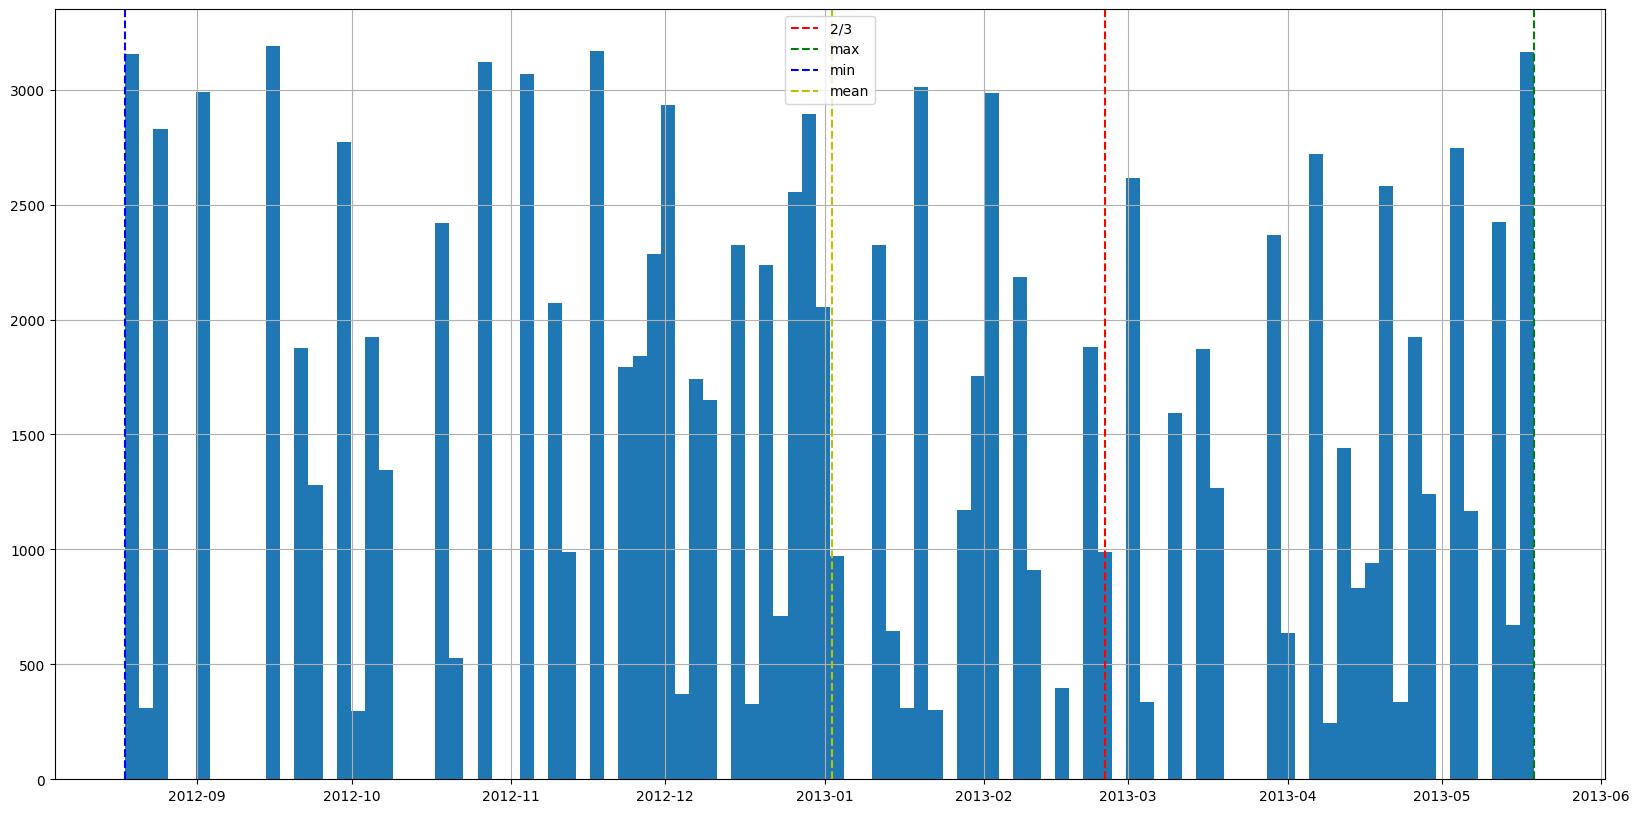

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
dates.hist(bins=100, ax=ax)

# Plot lines for date_2_3, dates.max(), dates.min(), dates.mean()
ax.axvline(date_2_3, color="r", linestyle="--", label="2/3")
ax.axvline(dates.max(), color="g", linestyle="--", label="max")
ax.axvline(dates.min(), color="b", linestyle="--", label="min")
ax.axvline(dates.mean(), color="y", linestyle="--", label="mean")

ax.legend()

left_c = ds[ds["date"] < date_2_3].shape[0]
right_c = ds[ds["date"] >= date_2_3].shape[0]

left_c, right_c, left_c / (right_c + left_c), right_c / (right_c + left_c)

In [43]:
# Select pairs of player_1 and player_2 that appear in the dataset
# Keep them in a test set

pairs = ds[["player_1", "player_2"]].drop_duplicates()
sample_pairs = pairs.sample(100)

test = ds[
    ds["player_1"].isin(sample_pairs["player_1"])
    & ds["player_2"].isin(sample_pairs["player_2"])
]
train = ds[
    ~ds["player_1"].isin(sample_pairs["player_1"])
    | ~ds["player_2"].isin(sample_pairs["player_2"])
    | ~ds["player_1"].isin(sample_pairs["player_2"])
    | ~ds["player_2"].isin(sample_pairs["player_1"])
]

train_left = train[train["date"] < date_2_3]
test_right = test[test["date"] >= date_2_3]

In [44]:
xgb_model = xgb.XGBRegressor()

X_train = train_left.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_train = train_left["target"]

X_test = test_right.drop(
    columns=["player_1", "player_2", "target", "date", "partido_id"]
)
y_test = test_right["target"]

xgb_model.fit(X_train, y_train)

sc = xgb_model.score(X_test, y_test)

mse = mean_squared_error(y_test, xgb_model.predict(X_test))

sc, mse

(-0.1629834634495786, np.float64(0.006091009603520992))

(0.0, 1.0)

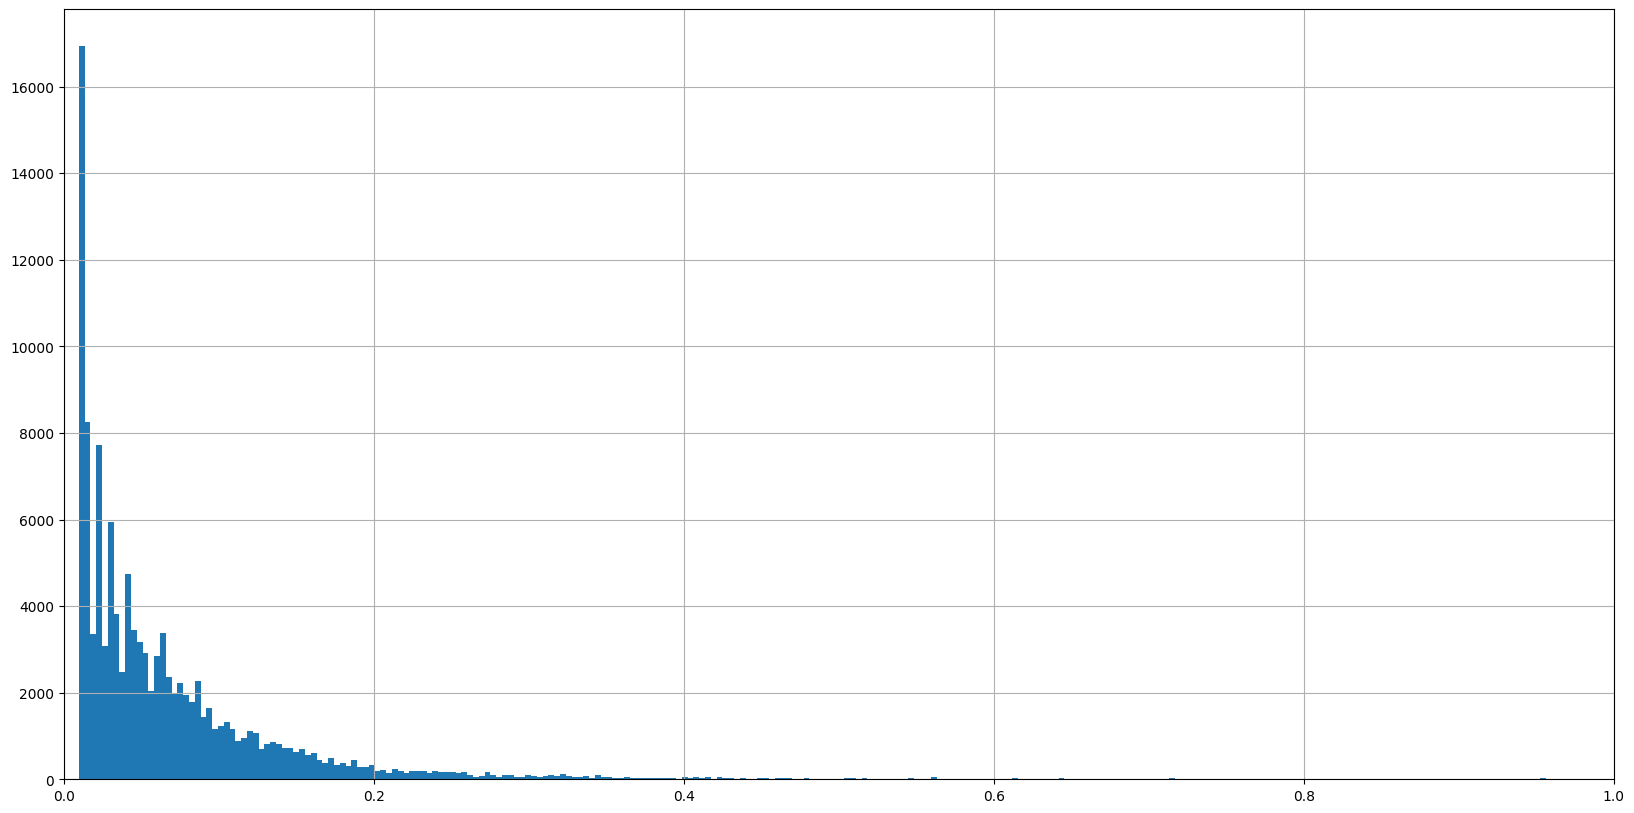

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))

ds["target"].hist(bins=1000, ax=ax)

ax.set_xlim(0, 1)

In [46]:
# Variance, mean, std, min, max for target

ds["target"].var(), ds["target"].mean(), ds["target"].std(), ds["target"].min(), ds["target"].max()

(np.float64(0.008503244578030554),
 np.float64(0.07147860218704535),
 np.float64(0.09221303908900604),
 np.float64(0.009765625),
 np.float64(3.750000000000013))

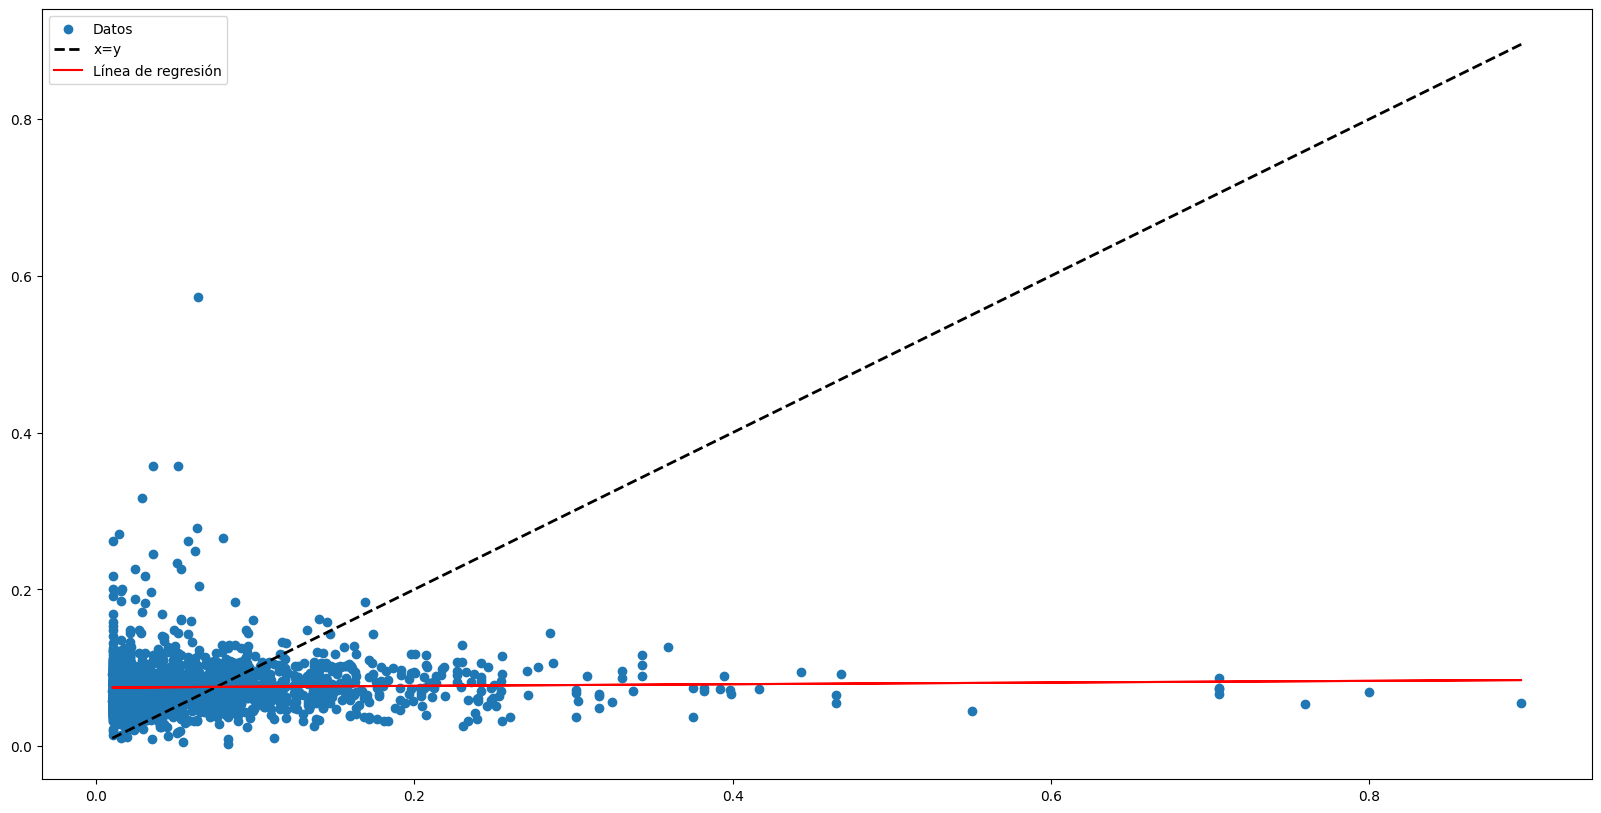

In [21]:
# Datos de prueba y predicciones
y_test = np.array(y_test)
y_pred = xgb_model.predict(X_test)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Dibujar el gráfico de dispersión
ax.scatter(y_test, y_pred, label="Datos")

# Dibujar la línea x=y
ax.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="x=y"
)

# Calcular la línea de regresión
reg = LinearRegression().fit(y_test.reshape(-1, 1), y_pred)
y_pred_line = reg.predict(y_test.reshape(-1, 1))

# Dibujar la línea de regresión
ax.plot(y_test, y_pred_line, color="red", label="Línea de regresión")

# Añadir leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


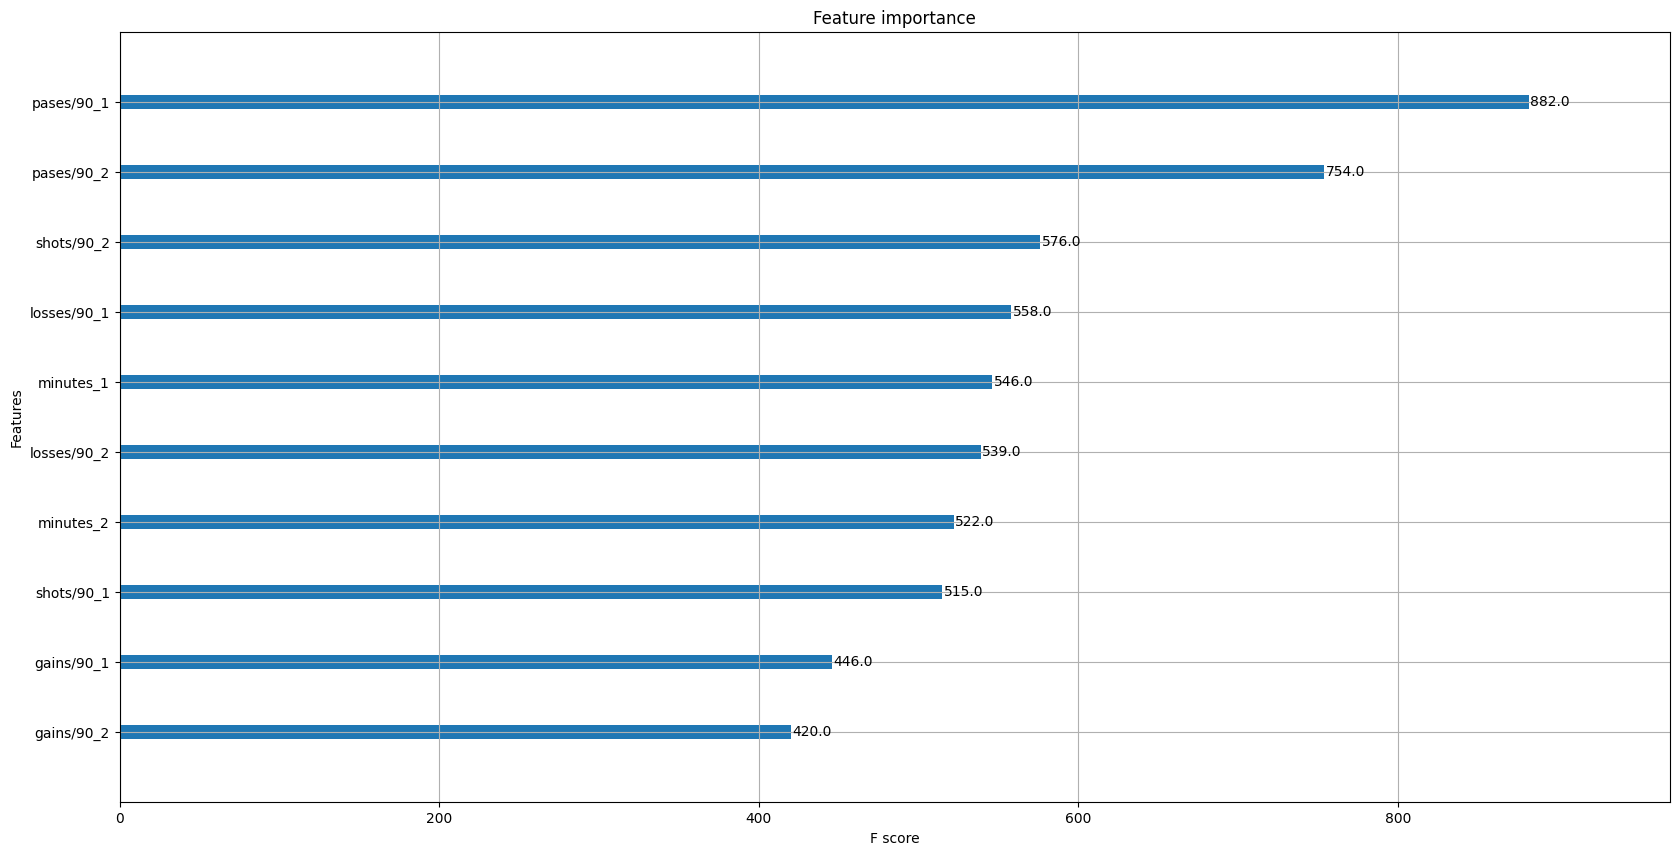

In [22]:
# Feature importance

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 10))

plot_importance(xgb_model, ax=ax)

plt.show()

In [50]:
import sys

sys.path.append("../")

from src.event_processing import leer_excel
from src.event_processing import separar_partido_del_equipo_en_lineups, separar_partido_en_equipo_pov, separar_partidos
from src.match_data_extraction import get_jugadores, get_lineup_duration
from src.utils_CMTC import psl_estimator, build_Q, build_R

epl = leer_excel("../SampleData/epl.xlsx")

In [66]:
partidos = separar_partidos(epl)
partidos = [partido for partido in partidos if partido["date"].values[0] > date_2_3]

sample_partido = partidos[np.random.randint(len(partidos))]

equipos = separar_partido_en_equipo_pov(sample_partido)
sample_equipo = equipos[np.random.randint(2)]
lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
sample_lineup = lineups[np.random.randint(2)]
jugadores = get_jugadores(sample_lineup)

jugador = jugadores[np.random.randint(len(jugadores))]
lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
psls = np.array([psl_estimator(build_Q(build_R(lineup))) for lineup in lineups])
lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

In [67]:
from src.futbol_types import TransitionMatrix
from src.utils_CMTC import build_R, build_Q
from src.match_data_extraction import get_lineup_duration
from src.utils_CMTC import psl_estimator, build_Q, build_R

In [68]:
from src.utils_CMTC import get_ratio_gains, get_ratio_loss, get_ratio_shots


def get_features(player_1, partido):
    # For a given player, get aggregated features for all matches played before partido
    # home_team_id if player_1 is in home team, away_team_id if player_1 is in away team
    team_id = partido[partido["player_id"] == player_1]["team_id"].values[0]

    player_data = {
        "pases/90": 0,
        "shots/90": 0,
        "losses/90": 0,
        "gains/90": 0,
        "minutes": 0,
    }

    # Get all matches played
    date = partido["date"].values[0]
    prev_matches = epl[epl["date"] < date]
    for partido in separar_partidos(prev_matches):
        for equipo in separar_partido_en_equipo_pov(partido):
            if equipo["team_id"].values[0] == team_id:
                if player_1 in get_jugadores(equipo):
                    for lineup in separar_partido_del_equipo_en_lineups(equipo):
                        players = get_jugadores(lineup)
                        if player_1 in players:
                            minutes = get_lineup_duration(lineup)
                            if minutes == 0:
                                continue

                            player_data["shots/90"] += get_ratio_shots(lineup, player_1)
                            player_data["losses/90"] += get_ratio_loss(lineup, player_1)
                            player_data["gains/90"] += get_ratio_gains(lineup, player_1)

                            player_data["minutes"] += minutes

                            passes = lineup[
                                (lineup["player_id"] == player_1)
                                & (lineup["type"] == 1)
                                & (lineup["outcome"] == 1)
                            ]

                            player_data["pases/90"] += passes.shape[0] / minutes

    return player_data

In [84]:
X_test.shape

(1943, 10)

In [108]:
from typing import List
from sklearn.base import RegressorMixin
from src.futbol_types import TransitionMatrix

def predicted_psl(p1: int, lineups: List[List[int]], model: RegressorMixin) -> TransitionMatrix:
    # Given Q and p1, update value for passes from p1 to every other player, and from every other player to p1
    counter = 0
    psls = []
    for lineup in lineups:
        jugadores = get_jugadores(lineup)
        R = build_R(lineup)
        for i, player in enumerate(jugadores):
            if player == p1:
                p1_features = pd.DataFrame([get_features(player, lineup)])
                for j, player2 in enumerate(jugadores):
                    if player2 != player:
                        counter += 1
                        p2_features = pd.DataFrame([get_features(player2, lineup)])
                        R[i + 1, j + 1] = model.predict(
                            pd.concat([p1_features, p2_features]).values.reshape(1, -1)
                        )[0]
                        R[j + 1, i + 1] = model.predict(
                            pd.concat([p2_features, p1_features]).values.reshape(1, -1)
                        )[0]

        Q = build_Q(R)
        psls.append(psl_estimator(Q))

    print(counter)
    lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

    return np.average(psls, weights=lineup_durations)

In [109]:
from src.utils_CMTC import team_psl

psl_ = predicted_psl(jugador, lineups, xgb_model)
psl = team_psl(sample_equipo)

psl, psl_, mean_squared_error([psl], [psl_])

30


(np.float64(0.019619676938909286),
 np.float64(0.01959153180420649),
 np.float64(7.921486074386319e-10))

In [110]:
bad_model = xgb.XGBRegressor(max_depth=1, n_estimators=1)
bad_model.fit(X_train, y_train)

psl_ = predicted_psl(jugador, lineups, bad_model)
psl = team_psl(sample_equipo)

psl, psl_, mean_squared_error([psl], [psl_])

30


(np.float64(0.019619676938909286),
 np.float64(0.01946529511486377),
 np.float64(2.383374759562125e-08))

In [111]:
sample_pairs

,player_1,player_2
5305,39529.0,11212.0
6172,19151.0,26900.0
13335,5750.0,49949.0
274939,76227.0,9110.0
108300,76359.0,13017.0
...,...,...
18180,40799.0,38429.0
191760,18681.0,59940.0
6698,18073.0,8380.0
182245,41823.0,48759.0


In [112]:
# For all matches > date+ 2/3 std,
# Get the psl for all players in the match
# Get a removed player from the Train ds (sample_pairs)
# Get the psl for the removed player

# Get all matches played

from typing import Tuple

date = date_2_3
matches = epl[epl["date"] >= date]
psl_diffs: List[Tuple[float, float]] = []

for partido in separar_partidos(matches):
    for equipo in separar_partido_en_equipo_pov(partido):
        lineups = separar_partido_del_equipo_en_lineups(equipo)
        for lineup in lineups:
            jugadores = get_jugadores(lineup)
            for player in jugadores:
                if player in sample_pairs["player_1"].values:
                    psl = predicted_psl(player, lineups, xgb_model)
                    psl_ = team_psl(equipo)
                    psl_diffs.append((psl, psl_))

psl_diffs = np.array(psl_diffs)

40
40
30
40
30
40
40
30
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
10
40
40


KeyboardInterrupt: 

In [124]:
psl_diffs_arr = np.array(psl_diffs)
psl_diffs_arr

array([[-5.38677230e-03,  3.50620158e-02],
       [-4.72061413e-03,  3.57281740e-02],
       [ 9.53827408e-05,  4.05441709e-02],
       [-4.72061413e-03,  3.57281740e-02],
       [ 9.53827408e-05,  4.05441709e-02],
       [-5.38677230e-03,  3.50620158e-02],
       [-4.72061413e-03,  3.57281740e-02],
       [ 9.53827408e-05,  4.05441709e-02],
       [-5.38677230e-03,  3.50620158e-02],
       [-5.38677230e-03,  3.50620158e-02],
       [-4.72061413e-03,  3.57281740e-02],
       [ 1.43913311e-03,  2.37339287e-02],
       [-2.01215876e-03,  2.02826369e-02],
       [-2.50060912e-03,  1.97941865e-02],
       [ 1.46134369e-06,  2.22962570e-02],
       [ 1.46134369e-06,  2.22962570e-02],
       [ 1.43913311e-03,  2.37339287e-02],
       [-2.01215876e-03,  2.02826369e-02],
       [-2.50060912e-03,  1.97941865e-02],
       [ 1.46134369e-06,  2.22962570e-02],
       [-2.50060912e-03,  1.97941865e-02],
       [ 1.43913311e-03,  2.37339287e-02],
       [-2.01215876e-03,  2.02826369e-02],
       [-2.

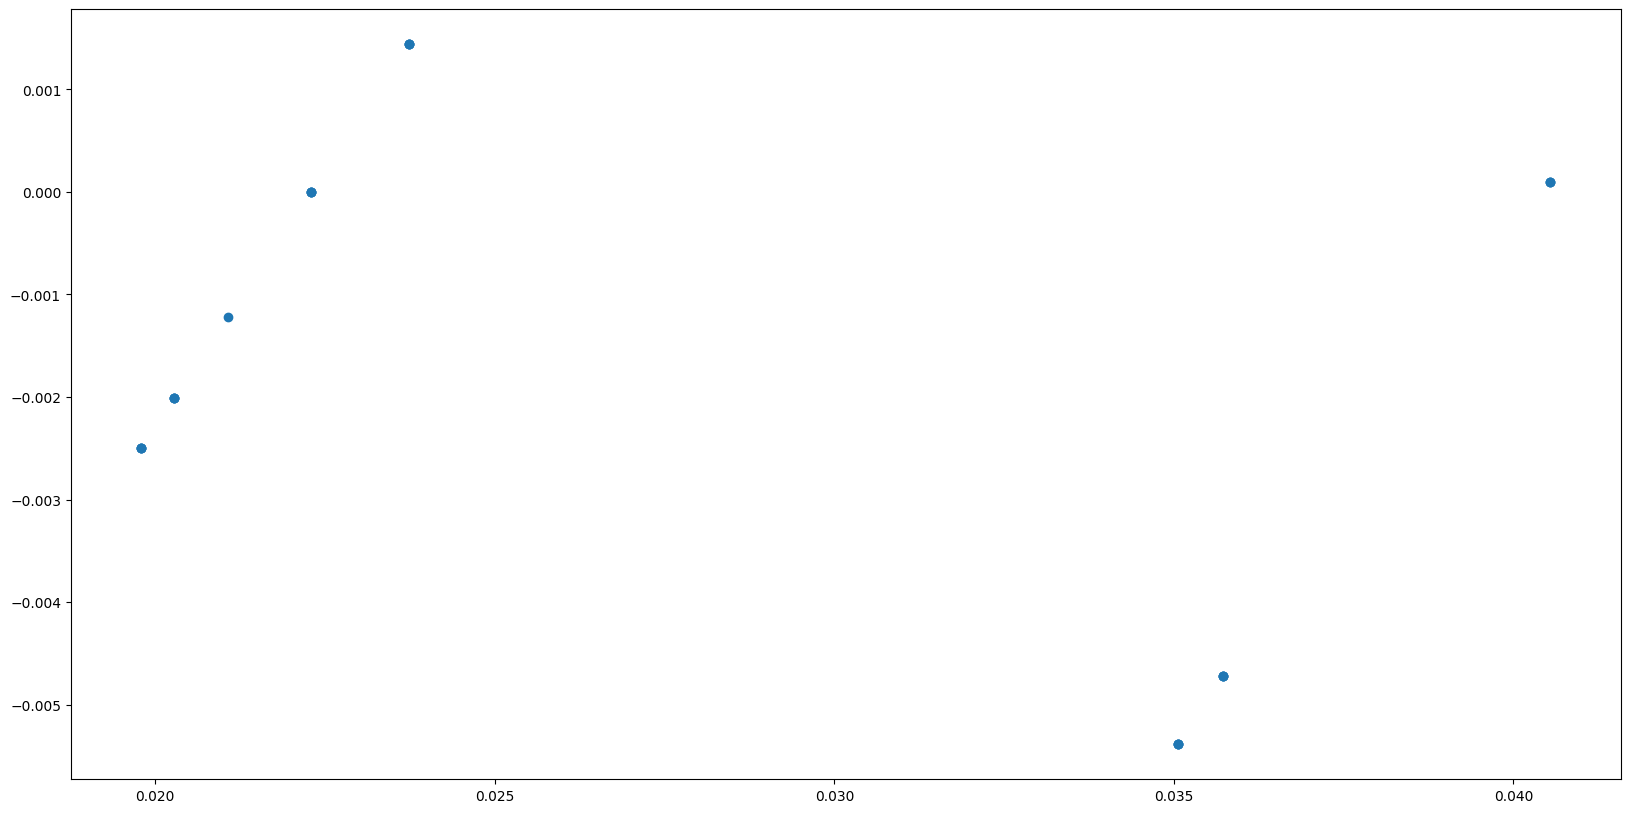

In [123]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(psl_diffs_arr[:, 1], psl_diffs_arr[:, 0], "o")
# ax.plot([0, 1], [0, 1], "k--")